In [1]:
import numpy as np
import scipy as sp
from scipy import stats

In [2]:
#####
# 
# helper functions
#
#####

def stand(x):
    '''Standardize a data series.
    
    Input: a 1-D numpy array
    Returns: the 1-D numpy array with values standardized'''
    
    return (x-np.mean(x))/np.std(x, ddof=0)

def get_breakpoints(a):
    '''Return list of breakpoints given cardinality a, used in SAX indexing.
    
    Input: integer a, representing number of breakpoints
    Returns: list of floats representing standard deviations from 0 mean, length (a - 1)'''
    
    avec = np.zeros(a-1)  # 1 less breakpoint than length
    for i in range(a-1):  
        avec[i] = sp.stats.norm.ppf((i + 1)/a, loc=0, scale=1) 
    return avec

def get_isax_word(ts, w, a):
    '''Given a time series, return iSAX word representation.
    
    Inputs:
    ts: time series
    w: number of chunks to divide time series
    a: cardinality (number of possible index values/levels per chunk)
    
    Returns: list of strings of length w, 
             each string represents a binary number having log2(a) digits
    
    Notes:
    Unexpected results may occur if cardinality is not 2^n for some n.
    Rounding errors may occur if w does not divide into length of time series evenly.'''
    
    # standardize time series
    series = stand(ts)
    
    # divide series into chunks
    if len(series) >= w:
        lenchunk = int(len(series)/w)
    else:
        # we choose to divide into unit chunks if length of series is not at least w
        lenchunk = 1
    
    # get averages of each bin
    means = [np.mean(series[int(lenchunk * chunk) : int(lenchunk * (chunk + 1))]) for chunk in range(w)]
    
    breakpoints = get_breakpoints(a)
    assert len(breakpoints) == (a-1)
    
    labels = np.arange(a)[::-1]  # reverse list so that 0 value is lowest y (most negative on std scale)
    assert len(labels) == a
    
    # convert to SAX code
    sax = np.empty(w, dtype=int)
    for i, item in enumerate(means):
        for j, b in enumerate(breakpoints):
            if item < b:
                sax[i] = int(labels[j])
                break
            elif j == len(breakpoints)-1:
                # that was the last breakpoint, value must be greater
                sax[i] = int(labels[j+1])
    
    # convert to binary format
    digits = int(np.log2(len(labels)))
    binarysax = [format(item, '0' + str(digits) + 'b') for item in sax]
    
    return binarysax

def distance(ts1, ts2):
    ''' Calculates Euclidian distance between two time series.
    
    Takes time series in the form of two 1-D numpy arrays. Assumes time series are of same length.
    Used by `find_nbr` in `iSaxTree` class to compare time series, but other distance measure can
    be substituted here.'''
    
    assert len(ts1) == len(ts2)

    d = (ts1 - ts2)**2
    d = d.sum(axis=-1)
    d = np.sqrt(d)

    return d

In [88]:
#####
# 
# file system functions
#
#####

# currently iSAX word (string) is used as the filename;
# these functions store the "files" in memory

# Note that the storage structure (alldata) works different from the `keyhashes` dictionary
# for the iSaxTree classes; the former only has an iSAX word index if there are existing time
# series being stored for it (e.g. upon deletion of all time series for that word, the entry
# from `alldata` is deleted.  However, in the `keyhashes` dictionary, iSAX words are stored
# for internal nodes (to which data items are not associated) and occasionally, for leaf nodes
# where all the corresponding time series have been deleted (i.e. nodes in the iSaxTree are
# NOT deleted even when they are empty.)

alldata = {}  # can be re-initialized if desired

def read_file(filename):
    # returns list of tuples [(time series as numpy array, time series ID), ...] indexed by filename
    templist = []
    try:
        templist = alldata[filename]
    except:
        pass
    return templist

def isax_exists(filename):
    # returns True if iSAX word has any time series stored for it
    return filename in alldata

def already_in_file(filename, ts):
    # returns True if a specific time series corresponding to an iSAX word is stored with the iSAX word
    if isax_exists(filename):
        data = read_file(filename)  # read data
        exists = np.any([np.array_equal(item[0], ts) for item in data])
        if exists:
            return True
    return False  # not in file

def write_to_file(filename, ts, tsid=""):
    # assumes already checked not in file
    # write time series to `filename` with optional ID
    if isax_exists(filename):
        alldata[filename] += [(ts, tsid)]
    else:
        # write new file / entry
        alldata[filename] = [(ts, tsid)]
        
def delete_from_file(filename, ts):
    # deletes time series from storage
    alldata[filename] = [item for item in alldata[filename] if not np.array_equal(item[0], ts)]
    if len(alldata[filename]) == 0:
        del alldata[filename]  # delete if empty

In [135]:
#####
# 
# set up tree structures
#
#####

class basicTree:
    '''Basic n-ary tree class.'''
    
    def __init__(self, data, parent=None):
        self.data = data
        self.parent = parent
        self.child_pointers = []  # stores of pointers to child nodes
        
    def add_child(self, data, level):
        n = self.__class__(data, self, level)
        self.child_pointers += [n]
        return n

    def num_children(self):
        return len(self.child_pointers)

    def isRoot(self):
        return not self.parent

    
class iSaxTree(basicTree):
    '''Implements modified version of iSAX tree.
    
    See: http://www.cs.ucr.edu/%7Eeamonn/iSAX_2.0.pdf for reference.
    In original form, during construction of iSAX indexing tree, multiple iSAX words have
    the root as parent, whereas internal nodes are limited to at most two children (see II. C.),
    and additionally, a node splitting policy is used to increase the likelihood that a given leaf
    being converted into an internal node will have its data more evenly distributed resulting in
    a more balanced tree.
    
    However, that implementation does not guarantee better balance, particularly if two series
    are very close in value throughout. Furthermore, the requirement that internal nodes be roots
    of binary subtrees appears to be needlessly restrictive.
    
    Accordingly, we adapt the n-ary nature of the top level of the iSAX tree for use at each 
    level; when a leaf node is to be converted into an internal node, the data to be re-stored 
    in a child node can take on any iSAX word value of the higher cardinality (i.e. we can have 
    more than 2 leaves per internal node, are are not limited to binary splits.) This is just as
    likely (if not more likely) to keep the tree balanced, while controlling the height of the tree.
    As new leaves do not result in the creation of a new file when empty, no additional file space
    is required to implement the n-ary subtrees.
    
    Notes:
    
    1. Currently only permits one instance of a time series to be stored (should be rare if values are
       floats). Duplicate time series are ignored, even if they have different labels. 
    
    2. Deleting a time series from tree requires series to be provided as input; 
       i.e. time series <-> series ID conversion not provided by this class.
    
    3. Assumes `alldata` is an accessible dictionary that stores time series data, with iSAX word as key,
       and value is a list of tuples [(time series as a numpy array, time series ID), ...]  Currently, 
       ISAX-indexed time series data is stored in memory; modifications are required to implement
       writes to persistent storage.
    
    Methods available:
    
    1.  (constructor) - initialize an instance of a tree with given label
            Usage: myTree = iSaxTree("root")
    2.  insert - insert a time series into the tree, optionally with a given ID (must identify with `tsid` if used)
            Notes: format of time series should be a 1-D numpy array
                   (e.g. array([ 26.02,  25.9 ,  25.71,  25.84,  25.98,  25.73,  25.61, ...);
                   may not work correctly if time series of different lengths are inserted
            Usage: myTree.insert(ts, tsid="Time Series ID")
    3.  delete - delete a time series from the tree; actual time series required as input
            Usage: myTree.delete(ts)
    4.  preorder - outputs as text structure of tree with counts of time series stored in each leaf node
            Usage: myTree.preorder()
    5.  preorder_ids - same as preorder, but list of IDs output along with counts
            Usage: myTree.preorder_ids()
    6.  find_nbr - performs an approximate search for nearest neighbor of input time series
            Notes: format of input/reference time series should be a 1-D numpy array;
                   the input time series need not be an existing time series in tree
            Usage: myTree.find_nbr(reference_ts)
    '''
        
    def __init__(self, data, parent=None, level=0):
        ''' Initializes tree (or subtree).
        
        Note: leave level unspecified to create root node of a new tree.'''
        
        super().__init__(data, parent)
        
        self.keyhashes = {}  # dictionary with isax words associated with this level as keys 
                             # and list of child_pointers as value
        self.level = level  # current level
        
        # adjustable parameters
        self.w = 4  # number of chunks 
        self.a = 4  # base cardinality
        self.TH = 5  # threshold number of series per file (can be increased for larger datasets)
        self.maxlevel = 10  # maximum depth (number of levels) in tree to split
        
        
    def insert(self, ts, level=1, tsid=""):
        ''' Attempt insertion at a given level of the tree (default is below root).
        
        Example usage: myTree.insert(ts, tsid="Time Series ID")
        
        Notes:
        1. Format of time series should be a 1-D numpy array
               (e.g. array([ 26.02,  25.9 ,  25.71,  25.84,  25.98,  25.73,  25.61, ...);
               may not work correctly if time series of different lengths are inserted
        2. Series ID (string) is optional, but must be specified with `tsid` if used.
        3. Currently, threshold for maximum number of series per file is applied up to 
               `maxlevel` to control height of tree; at `maxlevel` series is added to a child
               node even if threshold number of series is exceeded
        '''

        print ("attempting insert of", tsid)
        assert level == (self.level + 1)  # level to add node must be one below current node's level
        
        # get iSAX representation of input time series
        isax_word = str(get_isax_word(ts, self.w, self.a*(2**(level-1)))) # as string
        
        if already_in_file(isax_word, ts):
            # exact match already in file
            print ("did not insert - already in file")
            return
        
        if isax_word in self.keyhashes:  
            # a node for the same iSAX word has previously been created;
            # can be leaf or an internal node
            idx = self.keyhashes[isax_word]  # identify the pointer that points to the correct child
            node = self.child_pointers[idx]         
            
            if node.num_children() == 0:  
                # child is a terminal node / leaf
                assert node.data == isax_word
                if len(read_file(isax_word)) < self.TH:  # there is space to add series to the leaf
                    write_to_file(isax_word, ts, tsid=tsid)
                elif level == self.maxlevel:  # add to leaf if maximum depth reached (i.e. do not split further)
                    write_to_file(isax_word, ts, tsid=tsid)
                else:  # additional insert warrants a split, create an internal node
                    print ("creating new internal node at level", level)   
                    
                    # get all time series associated with this node and reinsert into new subtree
                    ts_list = alldata[isax_word]
                    for ts_to_move, itemid in ts_list:
                        node.insert(ts_to_move, level + 1, tsid=itemid)
                        delete_from_file(str(get_isax_word(ts_to_move, self.w, self.a*(2**(level-1)))), ts_to_move)
                    
                    print ("completed moving series from internal node into new nodes")
                    # insert input time series that triggered split 
                    # into a node in the new subtree (i.e. one level down)
                    node.insert(ts, level + 1, tsid=tsid)                       
            else:
                # child is an internal node (i.e. not a terminal node); traverse to next level
                node.insert(ts, level + 1, tsid=tsid)
        else:
            # new node to be created; add pointer to new terminal node in self's list
            self.keyhashes[isax_word] = self.num_children()  # 0-index
            write_to_file(isax_word, ts, tsid=tsid)
            self.add_child(isax_word, level)
            
        return
    
    def delete(self, ts, level=1):
        '''Delete a time series from the tree.
        
        Usage: myTree.delete(ts)'''

        # get iSAX representation of input time series
        isax_word = str(get_isax_word(ts, self.w, self.a*(2**(level-1)))) # as string
        
        if already_in_file(isax_word, ts):
            # exact match already in file
            print("match found - deleting")
            delete_from_file(isax_word, ts)
            return
        
        if isax_word in self.keyhashes:  
            # a node for the same iSAX word has previously been created;
            # can be leaf or an internal node
            idx = self.keyhashes[isax_word]  # identify the pointer that points to the correct child
            node = self.child_pointers[idx]         
            
            if node.num_children() == 0:  # child is a terminal node
                assert node.data == isax_word
                # if code reaches here, word is not in node otherwise it would have already been deleted
                # since it should be stored filed under `isax_word`
                print ("delete failed -- time series not in store")                    
            else:
                # child is an internal (i.e. not a terminal node); traverse
                node.delete(ts, level + 1)
        else:
            # there was no node created for this isax_word;
            # therefore it cannot be in tree
            print ("delete failed -- time series not in store")
        return
            
    def preorder(self):
        ''' Outputs structure of tree with counts of time series stored in each leaf node.
        
        Usage: myTree.preorder()'''
        
        if self.isRoot():
            print (self.data)
        else:
            if isax_exists(self.data):
                count = len(read_file(self.data))
            else:
                count = 0
            paddedstr = "---" * self.level + ">" + self.data + ": " + str(count)
            print (paddedstr)
        
        # recursively traverse tree
        for child_link in self.child_pointers:
            child_link.preorder()
            
    def preorder_ids(self):
        '''Same as preorder, but list of IDs are output along with counts.
        
        Usage: myTree.preorder_ids()'''
        
        if self.isRoot():
            print (self.data)
        else:
            if isax_exists(self.data):
                count = len(read_file(self.data))
                listing = [item[1] for item in read_file(self.data)]                
            else:
                count = 0
                listing = []
            paddedstr = "---" * self.level + ">" + self.data + ": " + str(count)
            print (paddedstr, sorted(listing))
            
        # recursively traverse tree  
        for child_link in self.child_pointers:
            child_link.preorder_ids()
    
    def preorder_str(self, l):
        '''Same as preorder_ids, but saves output as one big string.
        
        self: iSaxTree object
        l: log Class object
        
        Example usage:  
        myLog = log()
        stock.preorder_str(myLog)  # populate log string
        print (myLog.graph_as_string())'''
        
        if self.isRoot():
            paddedstr = self.data + "\n"
            l.graphstr += paddedstr
        else:
            if isax_exists(self.data):
                count = len(read_file(self.data))
                listing = [item[1] for item in read_file(self.data)]                
            else:
                count = 0
                listing = []
            paddedstr = "---" * self.level + ">" + self.data + ": " + str(count) + " " + str(sorted(listing)) + "\n"
            l.graphstr += paddedstr
            
        # recursively traverse tree  
        for child_link in self.child_pointers:
            child_link.preorder_str(l)
            
    def find_nbr(self, ts, level=1):
        ''' Performs an approximate search for nearest neighbor of input time series.
        
        Example usage: myTree.find_nbr(reference_ts)
        
        Notes: 
        
        1. Nearest neighbor is 'approximate' since we are taking advantage of the format 
           of the natural clustering provided by the iSAX tree to determine potential
           close matches. The intuition is that two similar time series are often 
           represented by the same iSAX word. Another algorithm that potentially performs
           an exhaustive search should be used if an exact search is required. 
        2. In the event that no neighbors with the same iSAX word can be found, neighboring
           series that share the same parent iSAX word (but not the root) are considered
           to find the nearest neighbor. Otherwise, a null suggestion is returned.
        3. The input/reference time series should be a 1-D numpy array;
           the input time series need not be an existing time series in tree.'''
                
        # get iSAX representation of input time series
        isax_word = str(get_isax_word(ts, self.w, self.a *(2**(level-1)))) # as string
        
        if isax_exists(isax_word):
            # exact isax word match found in file, retrieve all series
            ts_list = read_file(isax_word)
            print(len(ts_list), "neighbors with same iSAX word found")
            assert len(ts_list) > 0
            
            if len(ts_list) == 1:  # one entry, return it
                print ("closest neighbor:", ts_list[0][1])
                return ts_list[0][0]
            else:
                # calculate distances from reference series to each located series and return closest
                mindist = np.inf
                best_id = ""
                best_ts = None
                for item in ts_list:
                    tempdist = distance(ts, item[0])
                    if tempdist < mindist:
                        mindist = tempdist
                        best_id = item[1]
                        best_ts = item[0]
                print ("closest neighbor:", best_id)
                return best_ts
        
        if isax_word in self.keyhashes:  
            # if isax_word is in keyhashes dictionary, but not in file system
            # then this means we need to check the children for potential matches
            idx = self.keyhashes[isax_word]  # identify the pointer that points to the correct child
            node = self.child_pointers[idx]         
            
            if node.num_children()==0:  # child is a terminal node
                assert node.data == isax_word
                # if code reaches here, node was created but it is empty
                # create list of neighboring series from nodes that have shared parent
                ts_list = []
                for child in self.child_pointers:
                    try:
                        ts_list += read_file(child.data)
                    except:
                        pass  # node may exist, but no series are stored in the file system
                
                if len(ts_list)>0:
                    # calculate distances to each time series and return minimum
                    print(len(ts_list), "neighbors with same parent iSAX word found")
                    mindist = np.inf
                    best_id = ""
                    best_ts = None
                    for item in ts_list:
                        tempdist = distance(ts, item[0])
                        if tempdist < mindist:
                            mindist = tempdist
                            best_id = item[1]
                            best_ts = item[0]
                    print ("closest neighbor:", best_id)
                    return best_ts   
                else:
                    print ("no suggestions: no neighbors found at same level") 
                    return None                 
            else:
                # child is an internal (i.e. not a terminal node); traverse
                return node.find_nbr(ts, level + 1)
        else:
            # there was no node created for this isax_word
            print ("no suggestions: no time series corresponds to the same isax_word")

In [131]:
class log:
    def __init__(self):
        self.graphstr = ""
        
    def graph_as_string(self):
        return self.graphstr

# Testing: Random Time Series

In [17]:
from scipy.stats import norm
def tsmaker(m, s, j):
    '''
    Helper function: randomly generates a time series for testing.

    Parameters
    ----------
    m : float
        Mean value for generating time series data
    s : float
        Standard deviation value for generating time series data
    j : float
        Quantifies the "jitter" to add to the time series data

    Returns
    -------
    A time series and associated meta data.
    '''

    # generate metadata
    meta = {}
    meta['order'] = int(np.random.choice(
        [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))
    meta['vp'] = False  # initialize vantage point indicator as negative

    # generate time series data
    t = np.arange(0.0, 1.0, 0.01)
    v = norm.pdf(t, m, s) + j * np.random.randn(100)

    # return time series and metadata
    return np.array([list(item) for item in zip(t, v)])

In [144]:
########
#
# test driver
#
########

alldata = {}  # re-initialize "file system"
randts = iSaxTree("root")

# generate 200 time series of length 100
for i in range(200):
    series = np.array([item[1] for item in tsmaker(0, 1, 10)])  # extract series, assumes equal length
    randts.insert(series, tsid=('series '+str(i)))

attempting insert of series 0
attempting insert of series 1
attempting insert of series 2
attempting insert of series 3
attempting insert of series 4
attempting insert of series 5
attempting insert of series 6
attempting insert of series 7
attempting insert of series 8
attempting insert of series 9
attempting insert of series 10
attempting insert of series 11
attempting insert of series 12
attempting insert of series 13
attempting insert of series 14
attempting insert of series 15
attempting insert of series 16
attempting insert of series 17
attempting insert of series 18
attempting insert of series 19
attempting insert of series 20
attempting insert of series 21
attempting insert of series 22
attempting insert of series 23
attempting insert of series 24
attempting insert of series 25
attempting insert of series 26
attempting insert of series 27
attempting insert of series 28
attempting insert of series 29
attempting insert of series 30
attempting insert of series 31
creating new inter

In [32]:
randts.preorder()  # get structure with counts

root
--->['10', '01', '10', '01']: 0
------>['100', '011', '100', '011']: 0
--------->['1000', '0111', '1000', '0111']: 4
--------->['1000', '0110', '1001', '0111']: 2
--------->['1000', '0111', '1000', '0110']: 1
--------->['1001', '0111', '1000', '0110']: 3
------>['100', '011', '100', '010']: 4
--->['01', '01', '01', '10']: 0
------>['011', '011', '011', '100']: 5
------>['011', '011', '011', '101']: 1
--->['10', '10', '01', '10']: 0
------>['100', '100', '011', '100']: 0
--------->['1000', '1001', '0110', '1000']: 2
--------->['1000', '1000', '0110', '1000']: 3
--------->['1000', '1000', '0111', '1000']: 1
--------->['1000', '1000', '0110', '1001']: 1
------>['100', '100', '010', '100']: 2
--->['10', '01', '01', '10']: 0
------>['100', '011', '011', '100']: 0
--------->['1000', '0111', '0111', '1000']: 3
--------->['1001', '0110', '0111', '1000']: 2
--------->['1000', '0111', '0111', '1001']: 1
--------->['1000', '0110', '0111', '1001']: 4
--------->['1001', '0111', '0110', '1001']

In [33]:
randts.preorder_ids()  # see clusters of time series

root
--->['10', '01', '10', '01']: 0 []
------>['100', '011', '100', '011']: 0 []
--------->['1000', '0111', '1000', '0111']: 4 ['series 0', 'series 109', 'series 129', 'series 182']
--------->['1000', '0110', '1001', '0111']: 2 ['series 147', 'series 17']
--------->['1000', '0111', '1000', '0110']: 1 ['series 87']
--------->['1001', '0111', '1000', '0110']: 3 ['series 133', 'series 144', 'series 186']
------>['100', '011', '100', '010']: 4 ['series 136', 'series 142', 'series 16', 'series 75']
--->['01', '01', '01', '10']: 0 []
------>['011', '011', '011', '100']: 5 ['series 1', 'series 166', 'series 20', 'series 49', 'series 79']
------>['011', '011', '011', '101']: 1 ['series 169']
--->['10', '10', '01', '10']: 0 []
------>['100', '100', '011', '100']: 0 []
--------->['1000', '1001', '0110', '1000']: 2 ['series 135', 'series 2']
--------->['1000', '1000', '0110', '1000']: 3 ['series 106', 'series 178', 'series 50']
--------->['1000', '1000', '0111', '1000']: 1 ['series 57']
--------

In [147]:
timeserieslog = log()
randts.preorder_str(timeserieslog)
print (timeserieslog.graph_as_string())

root
--->['01', '01', '10', '01']: 0 []
------>['011', '011', '100', '011']: 0 []
--------->['0111', '0111', '1001', '0111']: 3 ['series 0', 'series 153', 'series 62']
--------->['0111', '0111', '1000', '0111']: 3 ['series 172', 'series 21', 'series 30']
--------->['0111', '0110', '1001', '0111']: 1 ['series 79']
------>['011', '011', '101', '011']: 5 ['series 113', 'series 187', 'series 36', 'series 73', 'series 90']
--->['10', '01', '01', '10']: 0 []
------>['100', '011', '011', '100']: 0 []
--------->['1000', '0111', '0110', '1001']: 2 ['series 1', 'series 137']
--------->['1000', '0111', '0110', '1000']: 4 ['series 17', 'series 38', 'series 6', 'series 96']
--------->['1001', '0111', '0110', '1000']: 1 ['series 24']
--------->['1000', '0110', '0110', '1001']: 1 ['series 31']
--------->['1000', '0111', '0111', '1000']: 4 ['series 131', 'series 196', 'series 33', 'series 34']
--------->['1001', '0110', '0111', '1000']: 3 ['series 190', 'series 55', 'series 72']
--------->['1000', '01

In [36]:
# test closest neighbor (may need to refresh a few times to get a match)
test = np.array([item[1] for item in tsmaker(0, 1, 10)])  # extract series
randts.find_nbr(test)

5 neighbors with same iSAX word found
closest neighbor: series 20


array([  5.62006074, -11.54996698,   2.61843915,   6.03777891,
        -1.29432393,  -4.75749178,  13.98024145, -14.41313272,
        -3.75068127,  -3.13846858,   7.32087192,  -5.0919071 ,
       -18.56309668,   8.91537188,  -2.57302966,  13.06306303,
        10.98519729,  22.55670695,   4.18778642,   2.36715794,
        -2.79061419,  -3.62393182,  -8.82551894,  -7.4356099 ,
        19.62531835,   6.25760294,  -3.94712292,   7.55221277,
       -12.47430499,   6.95829972,  10.86392034,   8.49922487,
        -3.08458912,  -5.40207023,  14.80942772,  -6.656254  ,
        -2.77975813,  22.16706343,   5.50541843,  -9.33644686,
        -2.4468169 ,  14.85003079, -12.34237984,  -5.37044117,
         8.89351418,  -5.82384634, -23.74614641,  27.20990745,
        -0.46230349,   3.33297713,   6.82458067,  -1.61204951,
       -11.07607445,   7.47430226,  -3.4789755 ,   3.05550793,
        -3.36085166,  -8.58138841,   5.02461585,   8.87057088,
        -5.46497175, -19.25693068,  11.93568476,   4.56

# Testing: Stock Data

In [37]:
import pandas as pd
stockdata = pd.read_csv("~/Desktop/sp500hst.txt", header=None)  # http://pages.swcp.com/stocks/#historical%20data
stockdata.columns = ["time", "symbol", "a", "b", "c", "close", "d"]
sdata2 = stockdata[["symbol", "time", "close"]]
sdata3 = sdata2.pivot('symbol', 'time', 'close')
sdata4 = sdata3.dropna(axis=0)  # remove rows with NA values
sdata4

time,20090821,20090824,20090825,20090826,20090827,20090828,20090831,20090901,20090902,20090903,...,20100806,20100809,20100810,20100811,20100812,20100813,20100816,20100817,20100819,20100820
symbol,,,,,,,,,,,,,,,,,,,,,
A,25.55,25.50,25.34,25.48,25.54,25.83,25.68,25.85,25.22,25.29,...,28.73,29.82,29.460,28.22,27.5300,27.35,27.16,29.28,28.54,28.56
AA,12.56,12.42,12.35,12.26,12.40,12.50,12.05,11.59,11.55,12.01,...,11.59,11.66,11.350,10.66,10.7295,10.64,10.60,10.95,10.66,10.57
ABC,21.05,20.80,20.93,20.90,21.15,21.20,21.31,21.20,21.01,21.14,...,30.24,30.05,29.970,29.12,29.1500,29.04,28.71,29.49,29.17,28.92
ABT,45.39,46.08,45.92,46.07,46.61,45.92,45.23,45.12,45.00,45.06,...,50.57,50.88,51.470,50.39,50.3900,50.06,50.34,50.69,49.32,49.34
ADI,28.42,28.24,28.37,28.64,28.59,28.68,28.25,27.76,27.56,28.15,...,30.17,30.49,29.890,29.09,28.2300,28.07,28.36,28.81,29.67,29.62
ADM,28.67,28.39,27.74,27.90,28.21,28.62,28.83,28.03,27.56,28.02,...,30.18,30.63,30.640,29.84,30.6000,30.05,30.04,30.78,30.23,30.52
AEE,27.05,27.20,27.29,27.46,27.53,27.57,26.97,26.99,26.61,26.85,...,27.20,27.31,27.620,27.02,26.7200,27.58,28.09,27.97,27.11,27.14
AEP,31.49,31.54,31.26,31.46,31.64,31.86,31.43,31.07,30.79,30.80,...,35.98,35.85,36.270,35.50,35.3500,35.52,35.73,35.76,34.84,34.82
AES,14.26,14.42,14.01,14.23,13.91,13.92,13.67,13.25,13.19,13.28,...,10.65,11.07,11.160,10.61,10.5900,10.62,10.66,10.93,10.58,10.40


In [132]:
########
#
# test driver
#
########

alldata = {}  # re-initialize "file system"
stock = iSaxTree("root")

# load data
for i in range(sdata4.shape[0]):
    print("processing stock", i)
    row = np.array(sdata4[i:i+1])[0]
    stock.insert(row, tsid=sdata4.index[i])

processing stock 0
attempting insert of A
processing stock 1
attempting insert of AA
processing stock 2
attempting insert of ABC
processing stock 3
attempting insert of ABT
processing stock 4
attempting insert of ADI
processing stock 5
attempting insert of ADM
processing stock 6
attempting insert of AEE
processing stock 7
attempting insert of AEP
processing stock 8
attempting insert of AES
processing stock 9
attempting insert of AET
processing stock 10
attempting insert of AFL
processing stock 11
attempting insert of AGN
processing stock 12
attempting insert of AIG
processing stock 13
attempting insert of AIV
processing stock 14
attempting insert of AIZ
processing stock 15
attempting insert of AKS
processing stock 16
attempting insert of ALL
processing stock 17
attempting insert of AMD
processing stock 18
attempting insert of AMP
processing stock 19
attempting insert of AMT
processing stock 20
attempting insert of AN
processing stock 21
attempting insert of ANF
processing stock 22
atte

In [39]:
stock.preorder()  # get structure with counts

root
--->['11', '10', '00', '10']: 0
------>['110', '100', '000', '100']: 4
------>['110', '101', '000', '100']: 2
------>['110', '101', '000', '101']: 1
------>['110', '100', '001', '101']: 1
------>['110', '100', '000', '101']: 1
--->['01', '00', '01', '11']: 0
------>['011', '001', '010', '111']: 5
------>['010', '001', '011', '111']: 2
------>['011', '001', '011', '111']: 1
------>['011', '001', '011', '110']: 1
------>['011', '000', '011', '111']: 1
--->['11', '10', '01', '00']: 0
------>['111', '100', '010', '001']: 5
------>['111', '101', '010', '000']: 2
------>['110', '101', '011', '000']: 2
------>['111', '101', '010', '001']: 0
--------->['1110', '1010', '0100', '0010']: 0
------------>['11100', '10101', '01001', '00100']: 1
------------>['11100', '10100', '01000', '00101']: 2
------------>['11100', '10101', '01000', '00100']: 1
------------>['11101', '10101', '01000', '00100']: 1
------------>['11101', '10100', '01001', '00100']: 1
--------->['1110', '1010', '0101', '0010']

In [126]:
stock.preorder_ids()  # see clusters of time series

root
--->['11', '10', '00', '10']: 0 []
------>['110', '100', '000', '100']: 4 ['A', 'JCI', 'JWN', 'PKI']
------>['110', '101', '000', '100']: 2 ['CCL', 'FO']
------>['110', '101', '000', '101']: 1 ['LMT']
------>['110', '100', '001', '101']: 1 ['TXT']
------>['110', '100', '000', '101']: 1 ['USB']
--->['01', '00', '01', '11']: 0 []
------>['011', '001', '010', '111']: 5 ['AA', 'AKS', 'CF', 'CSC', 'KG']
------>['010', '001', '011', '111']: 2 ['BAX', 'NOV']
------>['011', '001', '011', '111']: 1 ['CNX']
------>['011', '001', '011', '110']: 1 ['COG']
------>['011', '000', '011', '111']: 1 ['PFE']
--->['11', '10', '01', '00']: 0 []
------>['111', '100', '010', '001']: 5 ['ABC', 'D', 'EOG', 'RHT', 'WEC']
------>['111', '101', '010', '000']: 2 ['AVB', 'TIE']
------>['110', '101', '011', '000']: 2 ['AZO', 'NEM']
------>['111', '101', '010', '001']: 0 []
--------->['1110', '1010', '0100', '0010']: 0 []
------------>['11100', '10101', '01001', '00100']: 1 ['BF.B']
------------>['11100', '10100

In [143]:
mygraph = log()
stock.preorder_str(mygraph)
print(mygraph.graph_as_string())  # or do whatever with the string instead of printing

root
--->['11', '10', '00', '10']: 0 []
------>['110', '100', '000', '100']: 4 ['A', 'JCI', 'JWN', 'PKI']
------>['110', '101', '000', '100']: 2 ['CCL', 'FO']
------>['110', '101', '000', '101']: 1 ['LMT']
------>['110', '100', '001', '101']: 1 ['TXT']
------>['110', '100', '000', '101']: 1 ['USB']
--->['01', '00', '01', '11']: 0 []
------>['011', '001', '010', '111']: 5 ['AA', 'AKS', 'CF', 'CSC', 'KG']
------>['010', '001', '011', '111']: 2 ['BAX', 'NOV']
------>['011', '001', '011', '111']: 1 ['CNX']
------>['011', '001', '011', '110']: 1 ['COG']
------>['011', '000', '011', '111']: 1 ['PFE']
--->['11', '10', '01', '00']: 0 []
------>['111', '100', '010', '001']: 5 ['ABC', 'D', 'EOG', 'RHT', 'WEC']
------>['111', '101', '010', '000']: 2 ['AVB', 'TIE']
------>['110', '101', '011', '000']: 2 ['AZO', 'NEM']
------>['111', '101', '010', '001']: 0 []
--------->['1110', '1010', '0100', '0010']: 0 []
------------>['11100', '10101', '01001', '00100']: 1 ['BF.B']
------------>['11100', '10100

In [140]:
alldata.keys()

dict_keys(["['01', '11', '10', '00']", "['1101', '1010', '0011', '0100']", "['11101', '10100', '01001', '00100']", "['1110', '1000', '0011', '0100']", "['1110', '1011', '0011', '0010']", "['010', '010', '010', '111']", "['001', '100', '010', '111']", "['001', '010', '100', '111']", "['01', '01', '01', '10']", "['10', '11', '01', '01']", "['1110', '1011', '0010', '0100']", "['1100', '1010', '0001', '0111']", "['110', '101', '001', '001']", "['10', '10', '10', '00']", "['110', '011', '010', '011']", "['11101', '10010', '00100', '01001']", "['110', '100', '001', '101']", "['111', '011', '010', '010']", "['011', '001', '011', '111']", "['11101', '10101', '01000', '00100']", "['01', '10', '01', '01']", "['1101', '1010', '0101', '0010']", "['01', '10', '01', '10']", "['110', '100', '001', '011']", "['000', '011', '100', '111']", "['01', '10', '00', '10']", "['101', '100', '001', '101']", "['011', '010', '010', '110']", "['011', '001', '100', '110']", "['001', '101', '011', '110']", "['011', 

In [142]:
stock.data

'root'

In [41]:
# test case: should be able to pick up itself if given exact time series
test = np.array(sdata4[sdata4.index == "UNH"])[0]
stock.find_nbr(test)

4 neighbors with same iSAX word found
closest neighbor: UNH


array([ 28.92,  29.69,  29.92,  28.93,  28.94,  28.18,  28.  ,  27.33,
        28.66,  28.87,  28.88,  28.4 ,  29.11,  29.07,  28.76,  27.7 ,
        29.29,  29.34,  28.58,  28.59,  27.58,  26.68,  26.03,  25.34,
        25.8 ,  25.68,  25.04,  24.79,  24.28,  24.04,  24.38,  25.05,
        24.16,  24.67,  25.23,  24.29,  24.87,  24.55,  24.45,  24.92,
        25.96,  25.12,  25.71,  25.85,  25.31,  26.5 ,  25.88,  28.21,
        28.67,  29.13,  28.97,  29.37,  28.76,  29.08,  29.15,  28.97,
        28.87,  28.63,  28.56,  29.08,  29.56,  29.54,  29.44,  28.67,
        28.7 ,  28.29,  27.33,  27.46,  28.3 ,  28.46,  28.5 ,  30.31,
        30.48,  30.95,  31.32,  32.2 ,  31.82,  31.54,  32.17,  32.32,
        31.62,  31.68,  31.39,  30.85,  31.01,  30.48,  31.53,  31.48,
        31.79,  33.01,  32.7 ,  32.92,  32.05,  32.54,  33.32,  33.75,
        35.13,  34.55,  33.1 ,  33.16,  33.  ,  32.44,  33.24,  33.43,
        33.  ,  33.13,  34.05,  33.32,  32.46,  32.54,  32.41,  33.  ,
      

In [42]:
# deleting the test case and then looking for nearest neighbour should return closest in same cluster
stock.delete(test)
stock.find_nbr(test)

match found - deleting
3 neighbors with same iSAX word found
closest neighbor: POM


array([ 14.59,  14.55,  14.52,  14.54,  14.56,  14.57,  14.33,  14.18,
        14.02,  14.1 ,  14.17,  13.89,  13.99,  13.89,  14.1 ,  14.78,
        15.2 ,  15.17,  15.19,  15.25,  15.13,  15.09,  14.97,  14.93,
        15.08,  15.03,  14.88,  14.49,  14.34,  14.49,  14.78,  14.89,
        14.96,  15.08,  15.13,  14.91,  14.89,  15.2 ,  15.28,  15.49,
        15.23,  15.12,  15.12,  14.75,  14.46,  14.47,  14.38,  15.35,
        15.26,  15.61,  15.72,  15.66,  15.33,  15.49,  15.78,  15.74,
        15.65,  15.52,  15.54,  15.85,  16.05,  16.16,  16.02,  16.3 ,
        16.75,  16.93,  16.97,  16.92,  17.18,  16.87,  16.88,  17.07,
        17.4 ,  17.38,  17.28,  17.15,  17.01,  17.01,  17.27,  17.02,
        17.01,  17.27,  17.31,  17.31,  17.31,  16.85,  16.9 ,  16.71,
        16.86,  16.77,  16.6 ,  16.94,  16.92,  17.26,  17.27,  17.19,
        17.57,  17.43,  16.93,  16.38,  16.47,  16.56,  16.57,  16.52,
        16.42,  16.6 ,  16.61,  16.47,  16.03,  16.05,  15.91,  16.09,
      

In [43]:
# repeat different test: similar but using an orphan in a cluster
test2 = np.array(sdata4[sdata4.index == "CMA"])[0]
stock.find_nbr(test2)

1 neighbors with same iSAX word found
closest neighbor: CMA


array([ 27.09,  26.66,  26.29,  26.41,  26.35,  26.73,  26.67,  25.67,
        24.64,  25.16,  25.42,  27.05,  27.68,  27.6 ,  27.6 ,  28.87,
        31.36,  30.19,  30.65,  29.7 ,  29.77,  29.44,  28.81,  28.56,
        29.56,  29.82,  29.67,  28.37,  28.78,  29.98,  29.83,  30.42,
        29.86,  30.33,  30.16,  30.01,  31.43,  30.96,  29.95,  30.37,
        31.7 ,  30.23,  31.65,  30.79,  29.81,  29.09,  27.94,  27.19,
        27.57,  28.39,  28.01,  28.68,  27.99,  27.91,  28.5 ,  28.76,
        29.13,  28.07,  27.91,  28.66,  28.59,  28.73,  27.8 ,  28.47,
        28.34,  28.66,  27.66,  28.28,  27.48,  27.75,  28.48,  28.09,
        28.88,  29.24,  28.07,  27.94,  27.67,  28.25,  28.99,  29.46,
        29.62,  30.16,  29.78,  29.96,  30.04,  29.57,  30.5 ,  30.61,
        31.29,  32.99,  32.57,  32.22,  32.55,  33.16,  34.13,  32.86,
        33.04,  33.57,  35.82,  35.62,  35.5 ,  34.78,  35.39,  35.2 ,
        34.51,  35.45,  35.2 ,  34.54,  33.34,  34.03,  33.42,  34.05,
      

In [44]:
# deleting the test case should initiate search for neighbours that share the same parent
stock.delete(test2)
stock.find_nbr(test2)

match found - deleting
5 neighbors with same parent iSAX word found
closest neighbor: DIS


array([ 26.79,  26.8 ,  26.87,  27.  ,  27.01,  26.84,  26.04,  25.68,
        25.4 ,  25.44,  25.9 ,  26.95,  28.36,  28.42,  28.08,  28.29,
        28.37,  28.46,  28.44,  28.  ,  28.38,  28.08,  27.97,  27.62,
        28.23,  27.94,  27.46,  27.36,  27.21,  27.67,  28.18,  28.17,
        28.67,  28.64,  28.64,  28.41,  28.91,  29.23,  29.4 ,  29.87,
        29.35,  29.23,  29.44,  28.89,  28.65,  28.17,  27.24,  29.  ,
        28.56,  29.  ,  29.12,  29.29,  29.05,  30.44,  30.7 ,  30.87,
        30.67,  30.21,  30.01,  30.48,  30.23,  30.61,  30.35,  30.22,
        30.73,  30.79,  30.33,  30.84,  31.  ,  30.68,  30.7 ,  31.3 ,
        31.7 ,  31.83,  32.18,  32.43,  31.93,  31.95,  32.4 ,  32.31,
        32.43,  32.29,  31.91,  32.38,  32.28,  32.25,  32.07,  31.99,
        31.82,  31.83,  31.88,  31.36,  30.82,  31.29,  31.02,  30.6 ,
        31.01,  31.19,  30.61,  29.98,  29.92,  29.66,  29.32,  29.35,
        29.55,  29.52,  29.98,  30.75,  29.67,  29.54,  29.48,  29.84,
      

In [45]:
# if we delete all siblings sharing the same parent, we return no suggestion
stock.delete(np.array(sdata4[sdata4.index == "DIS"])[0])
stock.delete(np.array(sdata4[sdata4.index == "ETN"])[0])
stock.delete(np.array(sdata4[sdata4.index == "IFF"])[0])
stock.delete(np.array(sdata4[sdata4.index == "NSC"])[0])
stock.delete(np.array(sdata4[sdata4.index == "WHR"])[0])
stock.find_nbr(test2)

match found - deleting
match found - deleting
match found - deleting
match found - deleting
match found - deleting
no suggestions: no neighbors found at same level


## some graphs to compare neighbors in a cluster

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
sdata4[sdata4.index == "DNR"]

time,20090821,20090824,20090825,20090826,20090827,20090828,20090831,20090901,20090902,20090903,...,20100806,20100809,20100810,20100811,20100812,20100813,20100816,20100817,20100819,20100820
symbol,,,,,,,,,,,,,,,,,,,,,
DNR,16.77,16.88,15.74,15.59,15.45,15.41,15.22,14.74,14.65,14.76,...,16.78,16.9,16.69,16.03,15.82,15.74,15.45,15.68,15.22,14.69


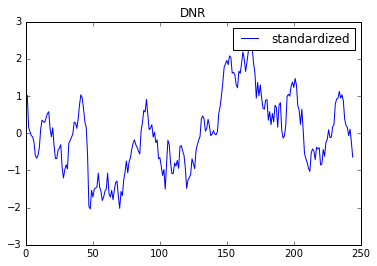

In [47]:
plt.plot(np.arange(245), stand(np.array(sdata4[sdata4.index == "DNR"])[0]), label="standardized")
plt.title("DNR")
plt.legend();

In [48]:
sdata4[sdata4.index == "MI"]

time,20090821,20090824,20090825,20090826,20090827,20090828,20090831,20090901,20090902,20090903,...,20100806,20100809,20100810,20100811,20100812,20100813,20100816,20100817,20100819,20100820
symbol,,,,,,,,,,,,,,,,,,,,,
MI,7.29,6.97,6.89,7.16,7.08,7.12,7.12,6.51,6.27,6.57,...,7.14,7.07,6.98,6.61,6.67,6.7,6.56,6.5,6.27,6.36


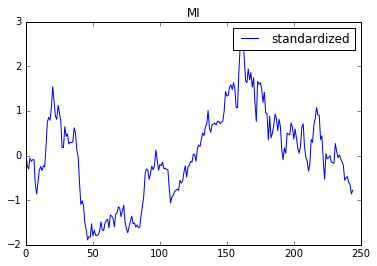

In [49]:
plt.plot(np.arange(245), stand(np.array(sdata4[sdata4.index == "MI"])[0]), label="standardized")
plt.title("MI")
plt.legend();

In [50]:
sdata4[sdata4.index == "UNM"]

time,20090821,20090824,20090825,20090826,20090827,20090828,20090831,20090901,20090902,20090903,...,20100806,20100809,20100810,20100811,20100812,20100813,20100816,20100817,20100819,20100820
symbol,,,,,,,,,,,,,,,,,,,,,
UNM,22.15,21.98,22.78,22.63,22.49,22.65,22.53,21,21.02,21.63,...,21.81,22.31,21.92,20.92,20.78,20.81,20.72,21.03,20.43,20.33


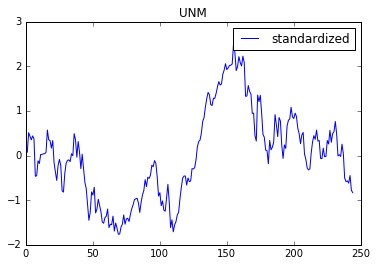

In [52]:
plt.plot(np.arange(245), stand(np.array(sdata4[sdata4.index == "UNM"])[0]), label="standardized")
plt.title("UNM")
plt.legend();

similar seasonable patterns observed

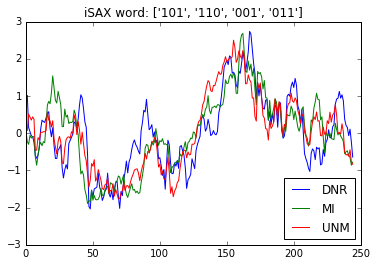

In [53]:
plt.plot(np.arange(245), stand(np.array(sdata4[sdata4.index == "DNR"])[0]), label="DNR")
plt.plot(np.arange(245), stand(np.array(sdata4[sdata4.index == "MI"])[0]), label="MI")
plt.plot(np.arange(245), stand(np.array(sdata4[sdata4.index == "UNM"])[0]), label="UNM")
plt.title("iSAX word: ['101', '110', '001', '011']")
plt.legend(loc="best");

In [57]:
########
#
# toy example
#
########

v1 = np.array([10, 12, -11, 1.5, 10, 13, 17])
v2 = np.array([8, 12, -11, 1.5, 10, 13, 17])

alldata = {}  # re-initialize "file system"
randts = iSaxTree("root")

randts.insert(v1, tsid='pk1')
randts.insert(v2, tsid='pk2')

randts.delete(v1)
randts.insert(v1, tsid='pk1')

attempting insert of pk1
attempting insert of pk2
match found - deleting
attempting insert of pk1


In [58]:
alldata

{"['01', '01', '11', '10']": [(array([  8. ,  12. , -11. ,   1.5,  10. ,  13. ,  17. ]),
   'pk2')],
 "['01', '01', '11', '11']": [(array([ 10. ,  12. , -11. ,   1.5,  10. ,  13. ,  17. ]),
   'pk1')]}